<a href="https://colab.research.google.com/github/amrit-thapa-2044/ICIMOD_permafrost_training_2022/blob/main/world_clim_data_download_duplicate_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<div align="center"><font size="4">REGIONAL TRAINING</font>**
<div align="center"><font size="4">Analysing permafrost in the Hindu Kush Himalaya using open access tools</font>

**<h1 align='center'>Downloading and Downscaling World Clim Mean Annual Temperature**

*This notebook is prepared for the participants of the regional training on **Analysing permafrost in the Hindu Kush Himalaya using open access tools** organized by [ICIMOD](https://rds.icimod.org/)through its cryosphere initiative under the Regional Programme on River Basins and Cryosphere in collaboration with Kathmandu university and Tribhuvan University.*

*The cryosphere initiative is supported by the Government of Norway and Swiss Agency for Development and Cooperation.*


Coded by: \
Amrit Thapa \
Email: amrit.thapa@icimod.org \
GitHub: https://github.com/amrit-thapa-2044

---



In this exercise, we download and prepare input data that are required to model permafrost distribution. We will download the [SRTM digital model](https://lpdaac.usgs.gov/documents/179/SRTM_User_Guide_V3.pdf), project it to  [UTM projection system](https://www.youtube.com/watch?v=HnWNhyxyUHg) and download it to derive incoming solar radiation in ArcGIS. We will then download mean annual air tempertaure (MAAT) climatology from World Clim, project it to utm and downscale it using the SRTM DEM and the lapse rate derived using a focal regression method. Finally, we will download downscaled MAAT to be used in the permaforst mapping exercise.

***This exercise is conducted using the [R programming language](https://cran.r-project.org/).***

# R packages and dependencies

An R package is a collection of functions that have been developed to cover specific scientific needs or methods that are not available in the R base language. They are commonly called *user libraries*. Such libraries must be installed by the user. These libraries are developed by the R community to address specific projects or scientific requirements. A *user library* may depend on functions from one or more other libraries, called *dependencies*. We can easily install packages in R using the ***install.packages*** function.

## Install Required Packages
This hands-on exercise requires the ***raster*** and ***rgdal*** packages. Let's install both libraries now.

In [ ]:
# install required packages
install.packages(c('raster','rgdal')) # may take more than 10 minutes

## Load required packages

Installing libraries is not sufficient. They must be loaded in order to be used. A package in R can be loaded using the ***library*** function.

In [ ]:
# load required libraries
library(raster)
library(rgdal)

# Define your area of interest (AOI)

Each project has its own boundaries. While some studies focus on a global scale, others may focus on a regional or even a local level. To define a boundary for your research site, you can simply use a shapefile (*.shp*). However, this might not always be feasible since you might have your own research boundary. In such a case, it is best to define the extent by using longitude and latitude of the lower left (*ll*) and upper right corner (*ur*) and georeference it to use it as spatial data.




## Define four corners of your area (AOI)

We can define an extent in R by using the ***extent*** function from the ***raster*** package. The function takes four arguments (xmin,xmax,ymin, ymax), where ***xmin*** is the lower x limit, ***xmax*** is the upper x limit, ***ymin*** is the lower y limit, and ***ymax*** is the upper y limit. The extent should always be ordered as follows: xmin,xmax, ymin, ymax.

For this exercise, we will define an extent of permafrost reserach site in Uttarakhand, India.

In [ ]:
#  User defined values for extent extent
xmin=78.07
xmax=80.5
ymin=29.80
ymax=31.5

Let's form an extent using user defined values. An enlarged extent with a buffer of 1 degree is also created around the acutal extent to crop larger downloaded datasets to save time during reprojection.

Additionally, the following code will also create an extended extent (buffer of 0.5 degree is taken in this exercise). This is useful as we often loose information at boundaries when we project.

In [ ]:
# extent
my_ext_actual <- extent(c(xmin,xmax,ymin,ymax ))

# enlarged extent to crop larger downloaded file
ff <- 1
my_ext_inlarge <- extent(c(xmin-ff, xmax+ff, ymin-ff, ymax+ff ))   #(xmin, xmax, ymin, ymax)

# extended extent 
f <- 0.5
my_ext <- extent(c(xmin-f, xmax+f, ymin-f, ymax+f  ))              #(xmin, xmax, ymin, ymax)


## Georeference your AOI

We are now going to convert the extent to a spatial object. Since we have a close boundary, we will create a spatial polygon based on our extent. You can do this easily by using the ***as*** function. The longitude and latitude of our extent are defined in WGS84, so we must also define the projection in the same format.

Using EPSG code, one can easily define a projection system. The epsg code of wgs84 is 4326. Similarly, epsg code of utm44n is 32644. More detail about epsg can be obtained from https://spatialreference.org/ref/epsg/.

In [ ]:
#@title
# convert extent to spatial polygon
my_ext_shp_actual <- as(my_ext_actual, 'SpatialPolygons')
my_ext_shp <- as(my_ext, 'SpatialPolygons')
my_ext_inlarge_shp <- as(my_ext_inlarge, 'SpatialPolygons')

# define projection using epsg code
projection(my_ext_shp)='+init=epsg:4326'
projection(my_ext_shp_actual)='+init=epsg:4326'
projection(my_ext_inlarge_shp)='+init=epsg:4326'

# visualize extent
plot(my_ext_inlarge_shp,axes=T,ylab='latitude',xlab='longitude',col='green')
plot(my_ext_shp,add=T,col='red')
plot(my_ext_shp_actual,add=T,col='blue')

## Project your AOI to UTM projection

In this exercise, we will use UTM projection. However, our boundary is in WGS84. Don't worry. By using the ***spTransform*** function in the ***raster*** package, we can easily change the projection of shapefiles.

***spTransform*** takes two important arguments (x,CRSobj).
- x : spatial object to be transformed
- CRSobj: object of the class CRS



In [ ]:
# change projection from WGS84 to UTM
my_extent_in_utm <- spTransform(my_ext_shp,CRS('+init=epsg:32644'))
my_extent_in_utm_actual <- spTransform(my_ext_shp_actual,CRS('+init=epsg:32644'))

# Visualize projected polygon
plot(my_extent_in_utm,axes=T,col='red')
plot(my_extent_in_utm_actual,add=T,col='blue')

# Download SRTM DEM

## Download SRTM Tiles

We can use ***getData*** function from the ***raster*** package to download SRTM DEM by defining longitude and latitude. 

SRTM DEM is available in different tiles, each with a size of 5 degree by 5 degree. We may require to download more than one tile if our area does not fall in a single tile. Let's download first tile by using any longitude and latitude inside our AOI.



In [ ]:
# downoad SRTM DEM by using my longitude and latitude
SRTM_1 <- getData('SRTM', lon=79, lat=31)

# plot output DEM
plot(SRTM_1)

# overlay our extent
plot(my_ext,add=T)

In the figure above, we can see that one tile of SRTM is not sufficient to cover our study site. Let's take a new longitude and latitude and download new tiles to the right.

In [ ]:
# download additional tile
SRTM_2 <- getData('SRTM', lon=82, lat=31)

# visualize SRTM tile
plot(SRTM_2)

# overlay  boundary
plot(my_ext,add=T)

The above additional tile covers the right side of the study area. It is now necessary to cover the lower side of the study area. Let's define longitude and latitude to download tiles located on the lower side of SRTM_1.

In [ ]:
SRTM_3 <- getData('SRTM', lon=79, lat=29)

# visualize SRTM tile
plot(SRTM_3)

# overlay  boundary
plot(my_ext,add=T)

The tile above covers the lower left side of our study area. Let's define a new longitude and latitude to cover the lower right side of the study site.

In [ ]:
SRTM_4 <- getData('SRTM', lon=82, lat=29)

# visualize SRTM tile
plot(SRTM_4)

# overlay  boundary
plot(my_ext,add=T)

## Mosaic SRTM tiles

We now downloaded all SRTM tiles that are required to cover our reserach site. Now we need to combine all tiles into a single raster object. We can easily do this in R using the ***mosaic*** function.

Usage

*mosaic(x, y, ..., fun)*

*x*: Raster object to be mosaicked

*y*: Raster object to be mosaicked

*...*	: Additional rasters mosaicked

*fun*: function. E.g. mean, min, or max. Must be a function that accepts a 'na.rm' argument





In [ ]:
# mosaic (join) all SRTM tiles
SRTM <- mosaic(x=SRTM_1,y=SRTM_2,z=SRTM_3,a=SRTM_4,fun=mean)

# get detail of mosaicked SRTM
print(SRTM)

# plot mosaiced
plot(SRTM)

# overlay boundary
plot(my_ext,add=T,lwd=2)

## Project and crop DEM tiles

Our objective is to project the SRTM DEM to UTM (90m). Let's get started. To reduce processing time when we project, let's crop the mosaicked SRTM before projection. It is a bit time-consuming to project the entire raster.

A raster can be cropped in R using the ***crop***. It takes two major arguments (x,y). *x*	is a raster object to be cropped and *y* is the boundary to be used to crop the raster.


In [ ]:
# crop
SRTM <- crop(x=SRTM,y=my_ext_inlarge)
plot(SRTM)

Now, we are ready to project our raster to UTM. This can be done using the ***projectRaster*** function. ***projectRaster*** takes four important arguments (*from,crs,method,res*). *from* is a raster to be projected. *crs* takes the parameters of the desired output projection, *method* is a resampling technique and *res* is the pixel size of output raster.

In [ ]:
# project to UTM with desired resolution
SRTM_utm_90m <- projectRaster(from=SRTM,crs='+init=epsg:32644',res=90, method='bilinear')

# get detail of projected DEM
print(SRTM_utm_90m)

# display projected DEM and overlay boundary
plot(SRTM_utm_90m)
plot(my_extent_in_utm,add=T, border="red")
plot(my_extent_in_utm_actual,add=T, border="blue")


Before exporting, let's crop the projected raster using the actual extent of our study site.

In [ ]:
# crop utm SRTM 90m for your extent
srtm_90m_my_ext_utm <- crop(SRTM_utm_90m,my_extent_in_utm)

# get detail about the cropped dem
print(srtm_90m_my_ext_utm)

# make plot of cropped dem
plot(srtm_90m_my_ext_utm)

# overlay extent over raster plot
plot(my_extent_in_utm,add=T, border = 'red')
plot(my_extent_in_utm_actual,add=T, border = 'blue')

## Export DEM of your AOI
Let's save the processed DEM (90m SRTM DEM projected to UTM and cropped by our extent) and download it. Raster can be exported in R by using the ***writeRaster*** function. This function takes four major arguments.

*x*: raster object to be saved

*filename*: desired filename of the output together with location to be saved

*format*: format of output raster

*overwrite*: local operation to decide whether to replace the file


In [ ]:
# before exporting let's crop using actual extent
srtm_90m_my_ext_utm_actual <- crop(srtm_90m_my_ext_utm,my_extent_in_utm_actual)

# export raster (90m STRM)
writeRaster(x=srtm_90m_my_ext_utm_actual,filename='/content/SRTM_90m_my_ext_actual_utm44n.tif',fortmat='GTiff',overwrite=T)

The output can now be downloaded by clicking the folder icon on the left side of the screen, followed by a right-click and a download.

We need a DEM of 1000m in addition to a 90m DEM for downscaling MAAT from 1000m to 90m. Let's create a 1000m DEM from 90m. This can be done by using the ***projectRaster*** function. ***projectRaster*** takes four important arguments (*from,crs,method,res*). *from* is a raster to be projected. *crs* takes the parameters of the desired output projection, *method* is a resampling technique and *res* is the pixel size of the output raster.

In [ ]:
# project 90m DEM to 1000m
srtm_1000m_my_ext_utm <- projectRaster(from=SRTM,crs='+init=epsg:32644',method='bilinear',res=1000)

#crop 1000m DEM using your extent
srtm_1000m_my_ext_utm <- crop(srtm_1000m_my_ext_utm,my_extent_in_utm)

# plot cropped DEM and overlay extent
plot(srtm_1000m_my_ext_utm)
plot(my_extent_in_utm,add=T,border = 'red')
plot(my_extent_in_utm_actual,add=T, border = 'blue')

# crop for actual extent
srtm_1000m_my_ext_utm_actual <- crop(srtm_1000m_my_ext_utm,my_extent_in_utm_actual)

# export raster (1000m DEM)
writeRaster(x=srtm_1000m_my_ext_utm_actual,filename='/content/SRTM_1000m_my_ext_actual_utm44n.tif',fortmat='GTiff',overwrite=T)

# Download and export WorldClim data 

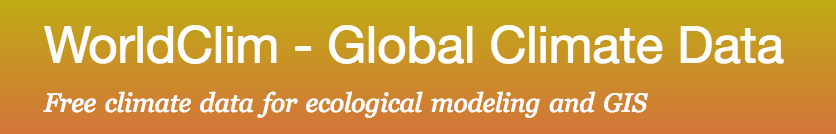

The use of bioclimatic variables is common in species distribution modeling and ecological modeling but also in hydrology, the cryosphere etc. Based on monthly temperature and rainfall values, these variables are calculated to create more meaningful variables. Further information can be found at https://www.worldclim.org/ .

## Download WorldClim data

Using the ***getData*** function of the ***raster*** package in R, we can download WorldClim data by defining latitude and longitude. The ***getData*** function takes five arguments (*name, var, res, lon, lat*). The dataset name is provided with the *name* argument, and the variable name is provided with the *var* argument. *res* is the spatial resolution of the WorldClim data to be downloaded, and *lat*, *lon* is any point/coordinate in our interest area. The output is a raster stack with all 19 variables of the WorldClim data.

**NOTE: WorldClim data has a scale factor of 10** [Temperature = 10ºC actually is 1 ºC].

The data is available in numerous tiles of 30 degrees by 30 degrees. If your area of interest does not fall into a single tile, you may need to download several tiles and mosaic them together.

Let's download WorldClim variables for a longitude and latitude within the extent that we defined earlier.

In [ ]:
# download WorldClim tile
r1 <- getData("worldclim", var="bio", res=0.5, lon=78, lat=31)

# get detail of output stack
print(r1)

# only plot first layer from the stack
plot(r1[[1]],main=names(r1)[[1]])

# overlay your extent and decide whether you need to download more tiles
plot(my_ext,add=T)

Above figure shows that we need additional tiles towards the south to cover our AOI. Let's download tiles towards the south by defining a new longitude and latitude and overlay our extent to decide whether to download more tiles.

In [ ]:
# download worldclim data
r2 <- getData("worldclim", var="bio", res=0.5, lon=78, lat=29)

In [ ]:
# make plot of first layer of stack
plot(r2[[1]]/10,main='Mean annual air temperature [MAAT]')

# overlay boundary
plot(my_ext,add=T)

Now we have all tiles that covers our extent. Let's combine all these tiles to form a single raster.

## Mosaic, project and crop WorldClim Data

The downloaded data set (stack) has 19 bioclimatic variables. However, we are only interested in the mean annual air temperature (MAAT), the first layer of the downloaded stack. We can extract any layer from the stack using the dollar operator ($) and the layer name. Let's pull MAAT from both downloaded stacks. Note that we already apply the scale factor (divison by 10 or a factor of 0.1) to plot realistic values of temperature rather than the raw data.

In [ ]:
# extract mean annual air temperature from first tile
MAAT_1 <- r1$bio1_18/10

# if you print the MAAT_1 object, now it will have a single layer which is mean annual temperature
print(MAAT_1)

# extract mean annual air temperature from second tile
MAAT_2 <- r2$bio1_28/10

# get detail
print(MAAT_2)

We can now combine the MAAT of both tiles to get one raster of our extent. A ***mosaic*** function in R can be used to create a raster object with a larger spatial extent. The function requires three arguments (*x,y,fun*). *x* and *y *are raster objects to be combined, and *FUN* is a statistical measure to compute cell values where layers overlap. To use the ***mosaic*** function, all objects must have the same origin, resolution, and coordinate reference system.

In [ ]:
# combine MAAT from two tiles to to form single raster object
MAAT=mosaic(MAAT_1,MAAT_2,fun=mean)

# get detail od combined raster
print(MAAT)

# make plot of combined raster and overlay extent
plot(MAAT,main='Mean annual air temperature')
plot(my_ext,add=T)

The original projection for WorldClim data is wgs84. 
The UTM projection system will be used to downscale mean annual temperature data from world climate.

Let's change the projection of MAAT to the UTM projection system and crop it to the extent we defined. By using a reference raster, one can directly perform projection and cropping. Let's do this.

We use the ***projectRaster*** function which takes three important arguments (*from, to, method*).

- *from* : raster object to be projected and cropped
- *to* :  reference raster object whose parameters have to be taken to project and crop from raster
- *method*: resampling method used to compute values of the output raster 

In [ ]:
# project and crop using reference raster
MAAT_1000m_utm_my_ext_degreeC <- projectRaster(from=MAAT,to=srtm_1000m_my_ext_utm,method='bilinear')

# get detail of repr0jected and cropped raster
MAAT_1000m_utm_my_ext_degreeC

# plot and overlay extent
plot(MAAT_1000m_utm_my_ext_degreeC)
plot(my_extent_in_utm,add=T,border ='red')
plot(my_extent_in_utm_actual,add=T,border = 'blue')

## Export mean annual temperature from WorldClim

It may be of interest to some of you to download projected MAAT with original spatial resolution of 1000m for your area of 
interest. The ***writeRaster*** function can be used to accomplish this. To use this function, you must provide four arguments (*x, filename, format, and overwrite*). *x* takes a raster object to export. The *filename* should include the location and name of the export. 
By specifying the *format*, the output file's format is defined. In addition, the logical argument *overwrite* is used to overwrite the output. Overwriting the same outfile multiple times after a revision is possible by using the *overwrite* argument (=TRUE).




In [ ]:
# crop by actual extent before exporting
MAAT_1000m_utm_my_ext_degreeC_actual <- crop(MAAT_1000m_utm_my_ext_degreeC,my_extent_in_utm_actual)

# export MAAT 1000m as tif
writeRaster(MAAT_1000m_utm_my_ext_degreeC_actual,'/content/MAAT_degreeC_1000m_my_ext_actual_utm44n.tif',format='GTiff',overwrite=TRUE)

# Downscale 1000m MAAT to 90m
We are now ready to downscale 1000m MAAT from WorldClim to 90m using the 90m SRTM DEM and lapse rate derived by using the focal linear regression method.

Let's calculate the lapse rate using focal regression. We will use a 3*3 pixel size to find the slope here.


## Derive lapse rate

A regression line was fitted between elevation raster (x,srtm_1000m_my_ext_utm) and MAAT (y, MAAT_1000m_utm_my_ext_degreeC). The slope of this regression is the lapse rate.

Let's create a new raster stack object *r* with  1000m SRTM and 1000m MAAT using the ***stack*** function.

In [ ]:
r <- stack(srtm_1000m_my_ext_utm,MAAT_1000m_utm_my_ext_degreeC)
plot(r)

Now we use a 3 by 3 focal linear regression method to derive the lapse rate (slope) over the whole raster. 
MAAT is the dependent variable, and elevation is the independent variable. 
Using a 3 by 3 moving window, we fit linear regression between MAAT and elevation and generate a slope raster.

In [ ]:
# Focal linear regression
w <- c(3,3) # 3x3 neighbour/group of cells

# initialize lapse raster
lapse_1_km <- r[[1]]

# redefine all value as NA
lapse_1_km[] <- NA

# loop to extract 3*3 pixels values and fit regression
for( rl in 1:nrow(r) ) { 
  # get 3 by 3 pixels values from 1000m MAAT and SRTM
  v <- getValuesFocal(r[[1:2]], row=rl, nrows=1, ngb = w, array = FALSE)
  fit <- rep(NA,nrow(v[[1]]))
  for(i in 1:nrow(v[[1]]) ) {
    # create data frame of x and y and remove NA values
    xy <- na.omit( data.frame(x=v[[1]][i,],y=v[[2]][i,]) )
    if( nrow(xy) > 4 ) {
      # extract slope from linear regression model
      fit[i] <- coefficients(lm(as.numeric(xy$y) ~ as.numeric(xy$x)))[2]
      if(is.null(fit)) fit = 1
    } else {
      fit[i] <- NA 
    }
  }
  lapse_1_km[rl,] <- fit # store slope value in grid
}

In [ ]:
# visaulize 1000m lapse rate grid
plot(lapse_1_km,main='1000m lapse rate')

# frequency distribution of pixels value of 1000m lapse grid
hist(lapse_1_km)

## Project data to 90m

We will project MAAT and lapse rate, and SRTM 1000m grids using the bilinear interpolation technique 
to the SRTM DEM (90m). We will use the ***projectRaster*** function. 

As projection uses surrounding pixels, it causes a loss of information at boundaries. We avoid this problem by projecting a raster using SRTM with a larger extent than the actual one and cropping it later by the actual boundary/extent.

In [ ]:
# project 1000m MAAT to 90m using srtm 90m as reference raster
MAAT_1000m_to_90_m <- projectRaster(MAAT_1000m_utm_my_ext_degreeC,srtm_90m_my_ext_utm,method='bilinear')
MAAT_1000m_to_90_m_actual <- crop(MAAT_1000m_to_90_m,srtm_90m_my_ext_utm_actual)

# project 1000m lapse rate grid to 90m using srtm 90m as reference raster
lapse_1000m_to_90m <- projectRaster(lapse_1_km,srtm_90m_my_ext_utm,method='bilinear')
lapse_1000m_to_90m_actual <- crop(lapse_1000m_to_90m,srtm_90m_my_ext_utm_actual)

# project 1000m SRTM to 90m using srtm 90m as reference raster
srtm_1000m_to_90m <- projectRaster(srtm_1000m_my_ext_utm,srtm_90m_my_ext_utm,method='bilinear')
srtm_1000m_to_90m_actual <- crop(srtm_1000m_to_90m,srtm_90m_my_ext_utm_actual)


In [ ]:
# make plot of projected MAAT, lapse and SRTM
plot(stack(MAAT_1000m_to_90_m_actual,lapse_1000m_to_90m_actual,srtm_1000m_to_90m_actual),main=c('MAAT-1000m','lapse rate-1000m','ELevation-1000m'))

## Downscale MAAT to 90m

Finally, we are ready to downscale MAAT from 1000m to 90m.

The elevation difference raster and the resampled lapse rate layer are multiplied. After this, the values of the grid cells are added to the mean annual temperature layer (originally a 1000m resolution grid that was then rescaled to 90m resolution) to construct the MAAT grid (90m).
For more detail, see Baral et al. (2019; https://doi.org/10.1002/ppp.2008 ).

In [ ]:
# apply formulae to downscale 1000m MAAT to 90m
MAAT_90m_downscaled_from_1000m <- MAAT_1000m_to_90_m_actual+(lapse_1000m_to_90m_actual*(srtm_90m_my_ext_utm_actual-srtm_1000m_to_90m_actual))

# get detail downscaled MAAT
MAAT_90m_downscaled_from_1000m

# make basic plot of MAAT (90m)
plot(MAAT_90m_downscaled_from_1000m,main='downscaled MAAT')

## Export downscaled MAAT

The final step is to save the downscaled mean annual temperature to the working directory and then download it to the local system. To do this, use the **writeRaster** function. Four arguments are required to use this function (*x, filename, format, and overwrite*). *x* takes a raster object to export. The *filename* should include the location and name of the exported image. In *format*, the format of the output file is defined, and the logical argument *overwrite* is used to overwrite the output. Using the *overwrite* argument (=TRUE) is useful if you need to generate the same outfile multiple times after a revision.


In [ ]:
# export raster (downscaled 90m MAAT)
writeRaster(x=MAAT_90m_downscaled_from_1000m,filename='/content/MAAT_degreeC_90m_downscaled_from_1000m_utm44n.tif',fortmat='GTiff',overwrite=T)

The output can now be downloaded by clicking the folder icon on the left side of the screen, followed by a right-click and a download. You can use any GIS software that you are comfortable with to visualize the downloaded data.

Assignment: 
- Make a map of 90m SRTM, 1000m SRTM, 1000m MAAT and downscaled 90m MAAT in any GIS software that you work with.
-Compare 90m and 1000m products.
- Make a copy of this script by clicking on file & save a copy in Drive and prepare data for your own extent (area).

: <h1 align='center'>**THANK YOU**</h1>